## Conformal Prediction

Conformal prediction computes confidence "intervals" associated to any black box prediction method, without assuming any prior model on the sample in the dataset. It computes the interval as quantile of runs of the method over the points in the dataset.

The main reference is

> Glenn Shafer, Vladimir Vovk, [A Tutorial on Conformal Prediction](https://jmlr.csail.mit.edu/papers/volume9/shafer08a/shafer08a.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate input data.

In [2]:
def phi0(x): return np.concatenate( (x*0+1, x, x**2, x**3), axis=1 )
n = 200 # number of points 
X0 = 8*( np.random.rand(n,1)-.5 )+.5
w0 = np.array([0,-5,0,1]) # coefficients
Y0 = phi0(X0) @ w0 + np.random.randn(n) * 7

Display data.

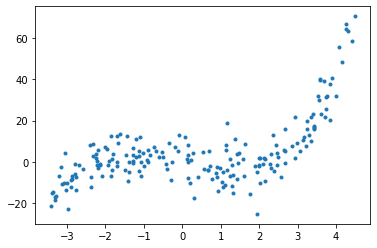

In [3]:
plt.plot(X0,Y0, '.');

We consider a simple least square method as estimator, but the method works for any black box function of some data $X = (x_i)_{i}$, $Y=(y_i)_i$

$$
    \hat y(x|X,Y) \triangleq \langle \varphi(x), \hat w(x|Z) \rangle
    \quad\text{where}\quad
    \hat w(x|X,Y) \triangleq
    \text{arg}\min_{w \in \mathbb{R}^d} \sum_i | \langle \varphi(z_i), w \rangle - y_i |^2
$$
where $\phi(x) \in \mathbb{R}^d$ is some feature vector.
We consider here polynomial features $\varphi(z) = (1,x,\ldots,x^{d-1})$.

In [4]:
def phi(x): return np.concatenate( (x*0+1, x, x**2, x**3), axis=1 )

Implements $\hat w(x|X,Y)$ and $\hat y(x|X,Y)$.

In [5]:
def hat_w(X,Y): return np.linalg.pinv(phi(X))@Y
def hat_y(x,w): return phi(x) @ w

Display the prediction at the sample of the dataset.

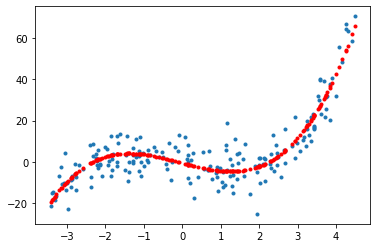

In [6]:
plt.plot(X0,Y0, '.')
plt.plot(X0, hat_y(X0,hat_w(X0,Y0)), 'r.');

The conformance function $S(x,y|X,Y)$ checkes the accuacy of the prediction
$$
    S(x,y|X,Y) \triangleq |y-\hat y(x|X,Y)|.
$$
To ease implementation, we implement it as a function of the parameter $w=\hat w(x|X,Y)$ of the model.

In [7]:
def S(x,y, w): return np.abs(y-hat_y(x,w))

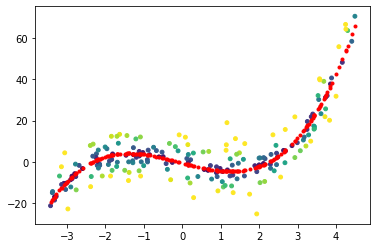

In [8]:
plt.scatter(X0,Y0,c=S(X0,Y0,hat_w(X0,Y0)), s=15, vmax=10)
plt.plot(X0, hat_y(X0,hat_w(X0,Y0)), 'r.');

The conformal prediction compute a score $C(x,y|X,Y)$ which is obtained by computing the rank of conformance at the point of interest
$$
    V \triangleq S(x,y| X \cup x, Y \cup y).
$$
among all possible scores at the samples 
$$
    V_i \triangleq S(X_i,Y_i| X \cup x, Y \cup y)
$$
This score is thus defined as
$$
    C(x,y|X,Y) \triangleq \frac{1}{n+1} \sum_{i} 1_{V_i \leq V}
$$

In [9]:
def conformal(x,y):
    V = np.zeros(n)
    w = hat_w(np.append(X0,x).reshape(n+1,1),np.append(Y0,y))
    for i in range(n):
        V[i] = S(X0[i,:].reshape(1,1),Y0[i], w)
    return (1 + np.sum( V<=S(np.array(x).reshape(1,1),y, w) ) ) / (n+1)

For some confidence level $\alpha \in [0,1]$, this scores defines a confidence "interval" (it does not need to be connected, but in most cases it is)
$$
    I_\alpha(x|X,Y) \triangleq \{ y : C(x,y|X,Y) \leq 1-\alpha \}. 
$$
The fundamental theorem of conformal prediction is that this interval has a covering property, in the sense that 
$$
    \mathbb{P}(y \in I_\alpha(x|X,Y)) \geq 1-\alpha
$$
where the probability is taken with respect to random $(x,y,X_1,\ldots,X_n,Y_1,\ldots,Y_n)$, all assumed to be independant and identically distributed. 

We compute the value of $C(x,y|X,Y)$ on a grid of $x$ and $y$.

In [10]:
nx = 80
ny = 70
xlist = np.linspace(min(X0),max(X0),nx)
ylist = np.linspace(min(Y0),max(Y0),ny)
R = np.zeros((nx,ny))
for ix in range(nx):
    for iy in range(ny):
        R[ix,iy] = conformal(xlist[ix],ylist[iy])

Display the confidence intervals as level sets of the function $C(\cdot,\cdot,X,Y)$.

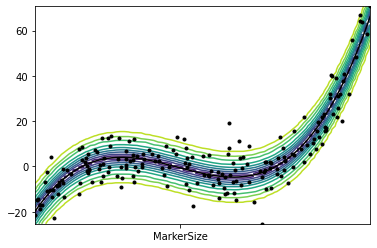

In [11]:
CS = plt.contour(xlist.flatten(),ylist.flatten(), R.T, levels=np.linspace(0,1,11))
plt.plot(xlist.flatten(), hat_y(xlist,hat_w(X0,Y0)), 'k-')
plt.plot(X0,Y0, 'k.', 'MarkerSize', 15)
plt.axis([min(X0),max(X0),min(Y0),max(Y0)]);